## Encoding

If we want to do computation with spiking neurons, the first question to ask ourselves is how to encode data (images, video, audio, text, etc.) into spikes. We can approach this problem from either a purely practical perspective or be guided by what is known from biological nervous systems. Biological nervous systems also process additional sensory modalities which aren't typically considered in the machine learning literature, such as smell, touch, etc.

In Norse we operate primarily on tensors of data, irrespective of the origin of this data. For
example an image naturally is encoded as a tensor with shape (C, W, H), where C is the number
channels (colors), W is the width and H is the height of the image. 

In this notebook you will explore
- an overview of some of the encoders build into Norse
- project ideas related to encoding 

## Step 0: Installation

First of all, we will need to install Norse. Please run the cell below. Read on while it's running.

In [ ]:
!pip install --quiet norse

The following is an implementation of two helpful functions to visualise 2d spike trains
as they are produced by norse.

In [52]:
import norse
import torch
import matplotlib.pyplot as plt

def plot_activity_2d(fig, z : torch.Tensor):
    channels = z.shape[2]
    B = z.shape[1]
    T = z.shape[0]
    for c in range(channels):
        ax = fig.add_subplot(1, channels, c+1)
        s = ((z[:,:,c].sum(axis=0)/T).sum(axis=0)/B)
        ax.matshow(s)

def plot_spikes_2d(fig, z):
    T = z.shape[0]
    C = z.shape[1]

    for c in range(C):
        ax = fig.add_subplot(1, C, c+1, projection='3d')
        s = z[:,c].detach().to_sparse().coalesce()

        ax.invert_yaxis()
        ax.invert_zaxis()
        ax.set_xlim([0,T])
        ax.set_xlabel('time [ms]')
        ax.scatter(s.indices()[0], s.indices()[2], s.indices()[1], s=1.0, c=s.values())

## Step 1: Built in Encoders

In order to convert non-spiking data to spikes one convenient way
are to use an encoding as a Poisson spike train

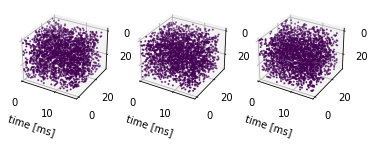

In [63]:
z = norse.functional.encode.poisson_encode(1.4 * torch.ones(16, 3, 32, 32), seq_length=48)
fig = plt.figure()
plot_spikes_2d(fig, z[0,:])

Another is to treat the data as a constant input current to a LIF 
neuron. In this case the latency between consecutive spikes,  aswell as the overall firing frequency, carries the information 
about the encoded data.

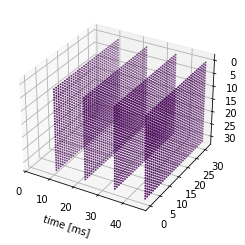

In [70]:
T = 48
v_th = 1.0

z = norse.functional.encode.constant_current_lif_encode(
    1.4 * torch.ones(1, 32, 32), 
    p=norse.torch.functional.lif.LIFParameters(v_th=torch.as_tensor(v_th)),
    seq_length=T
)
fig = plt.figure()
plot_spikes_2d(fig, z)

Exercise:
- Change the threshhold voltage (v_th), what happens? Why?
- Change other neuron parameters (hint they can be found by executing the cell below)

In [67]:
norse.torch.functional.lif.LIFParameters?

Init signature:
norse.torch.functional.lif.LIFParameters(
    tau_syn_inv: torch.Tensor = tensor(200.),
    tau_mem_inv: torch.Tensor = tensor(100.),
    v_leak: torch.Tensor = tensor(0.),
    v_th: torch.Tensor = tensor(1.),
    v_reset: torch.Tensor = tensor(0.),
    method: str = 'super',
    alpha: float = tensor(100.),
)
Docstring:     
Parametrization of a LIF neuron

Parameters:
    tau_syn_inv (torch.Tensor): inverse synaptic time
                                constant (:math:`1/\tau_\text{syn}`) in 1/ms
    tau_mem_inv (torch.Tensor): inverse membrane time
                                constant (:math:`1/\tau_\text{mem}`) in 1/ms
    v_leak (torch.Tensor): leak potential in mV
    v_th (torch.Tensor): threshold potential in mV
    v_reset (torch.Tensor): reset potential in mV
    method (str): method to determine the spike threshold
                  (relevant for surrogate gradients)
    alpha (float): hyper parameter to use in surrogate gradient computation
File:        

Discuss: 
- What other encoders might be useful?

## Step 2: Image Data

In [ ]:
We can test out these encoders on "real" data: Namely the beloved MNIST dataset.

In [59]:
import torchvision

batch_size = 32

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

train_data = torchvision.datasets.MNIST(
    root=".",
    train=True,
    download=True,
    transform=transform,
)

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

Exercise:
- Try out a different dataset an overview can be found [here](https://pytorch.org/docs/stable/torchvision/datasets.html).

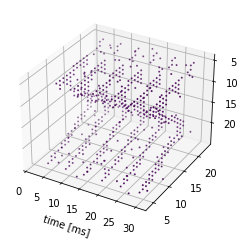

In [71]:
img, label = train_data[0]

T = 32
z = norse.functional.encode.constant_current_lif_encode(img, seq_length=T)

fig = plt.figure()
plot_spikes_2d(fig, z)

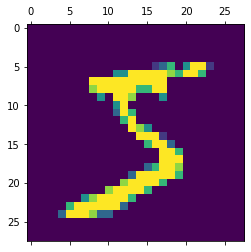

In [72]:
fig = plt.figure()
plot_activity_2d(fig, z.unsqueeze(1))

## Step 3: Project Ideas

- Find out about Adress Event encoded data, such as the one produced by DVS cameras and
think of an interesting task to implement. We have implemented
a library which will allow you to directly import adress event encoded data into Norse:
[aedat](https://github.com/norse/aedat)
- Design a task which uses a biologically plausible Audio to Spike conversion like
  [lauscher](https://github.com/electronicvisions/lauscher).
- What other data could be used as input to a Spiking Neural Network and how?